In [1]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 1261, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 1261 (delta 42), reused 56 (delta 10), pack-reused 1131 (from 2)
Receiving objects: 100% (1261/1261), 123.88 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (569/569), done.
Updating files: 100% (371/371), done.


In [2]:
cd Tidal_try

/content/Tidal_try


training BiLSTM no utide 27...
Epoch 1/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.1548 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 2/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0333 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 3/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0192 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 4/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0131 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 5/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0099 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 6/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0079 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 7/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0066 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 8/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0056 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 9/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0050 - val_loss: 0

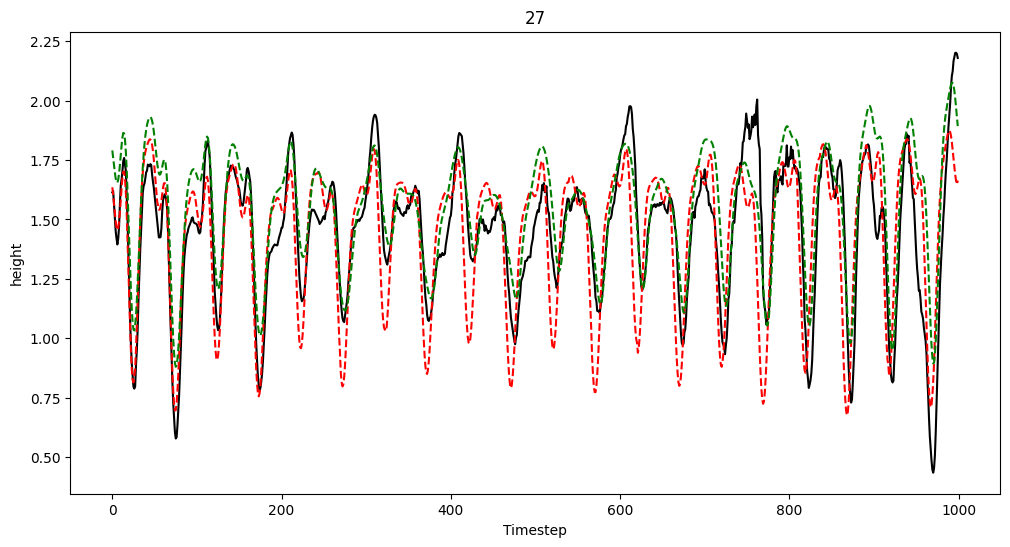

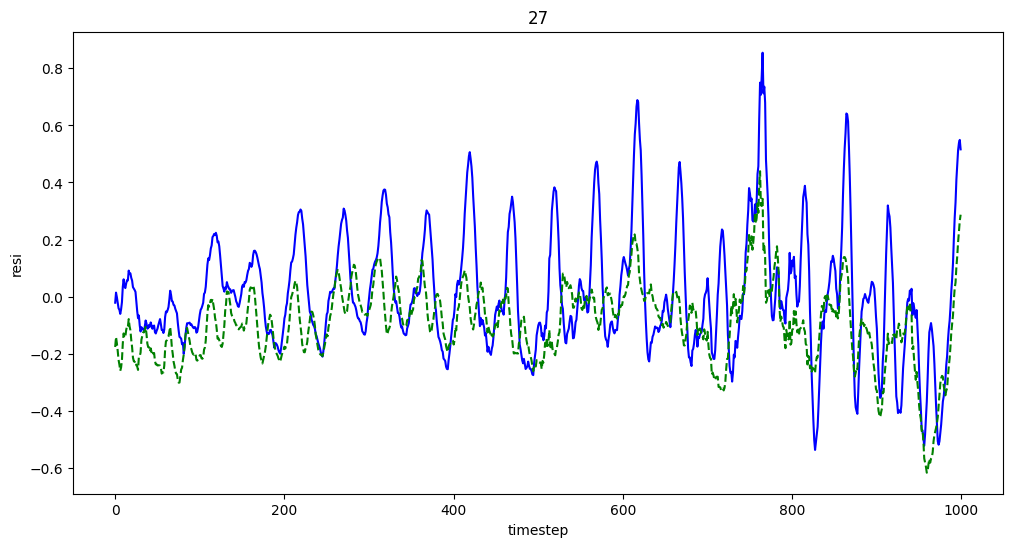

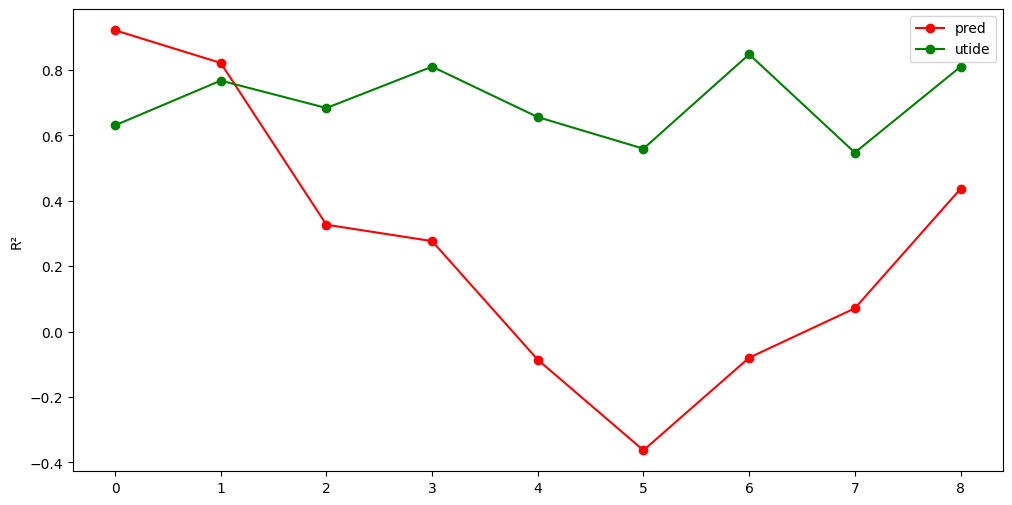

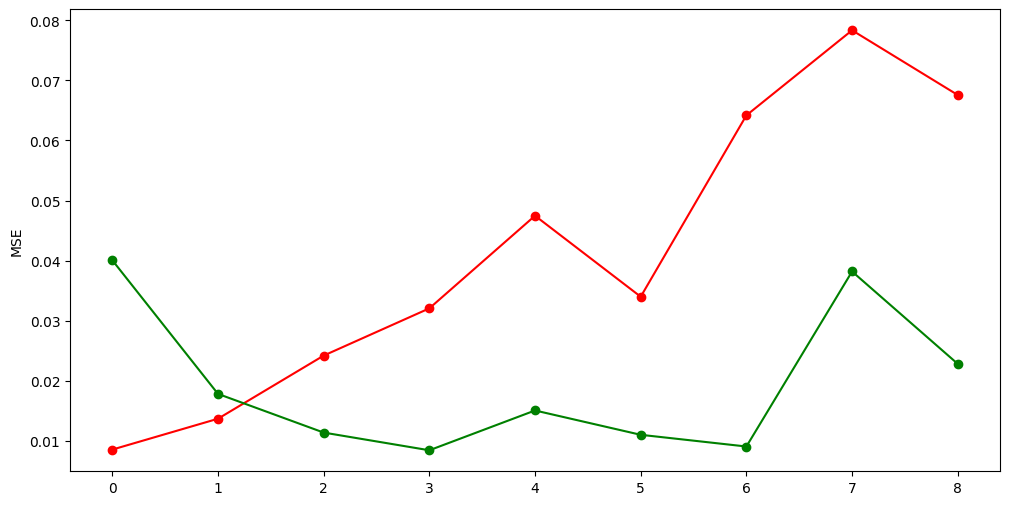

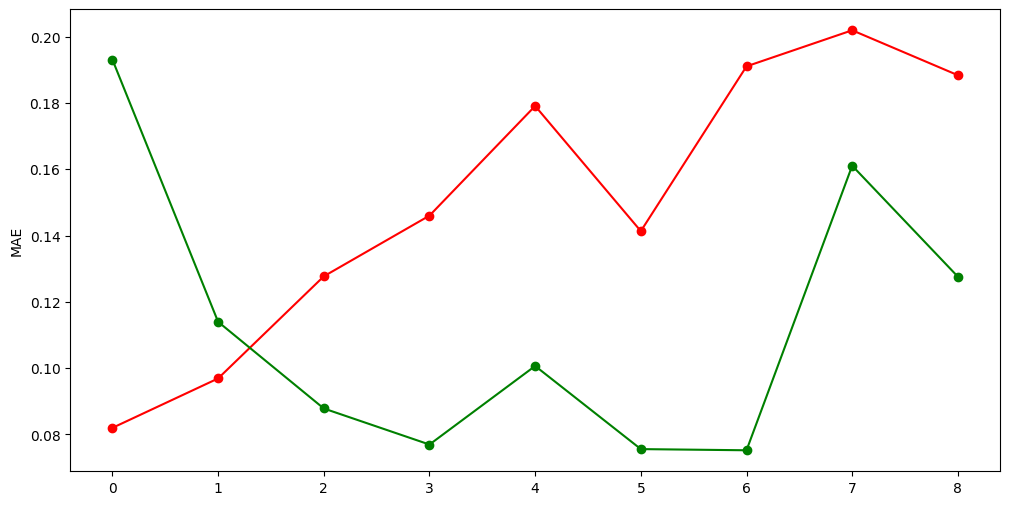

In [15]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(3407)
np.random.seed(3407)
tf.random.set_seed(3407)

input_file = "dataProcessed/BOU2019_HA.csv"
df = pd.read_csv(input_file, delimiter=',')

total_train = 31964
look_back = 100
total_test = 2976
start_index = 0
future_steps_list = [27]


total = total_train + look_back + total_test

df_sampled = df.iloc[start_index:start_index + total].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_or = df_sampled['tide_h'].values.reshape(-1, 1)

scaler_anomaly_train = MinMaxScaler(feature_range=(0, 1))
scaler_anomaly_train.fit(anomaly)
anomaly_scaled = scaler_anomaly_train.transform(anomaly)

train_single = anomaly_scaled[:total_train]
test_single = anomaly_scaled[total_train: total_train + total_test + look_back]

def dataset1(dataset, look_back, future_steps):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - future_steps + 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        future_values = [dataset[i + look_back + j, 0] if dataset.ndim > 1 else dataset[i + look_back + j] for j in range(future_steps)]
        dataY.append(future_values)
    return np.array(dataX), np.array(dataY)

def inverse1(arr_scaled):
    arr_scaled = arr_scaled.reshape(-1, 1)
    return scaler_anomaly_train.inverse_transform(arr_scaled).flatten()

def biLSTM(input_shape, future_steps):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(future_steps)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

no_utide = {
    'future_steps': [],
    'Time_Step': [],
    'Actual_Values': [],
    'Predicted_Values': [],
    'Utide_Values': []
}

for future_steps in future_steps_list:
    trainX_single, trainY_single = dataset1(train_single, look_back, future_steps)
    testX_single, testY_single = dataset1(test_single, look_back, future_steps)

    trainX, valX, trainY, valY = train_test_split(trainX_single, trainY_single, test_size=0.1, random_state=3407)

    model = biLSTM((look_back, 1), future_steps)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
    epochs = 80
    batch_size = 256

    print(f"training BiLSTM no utide {future_steps}...")
    history = model.fit(
        trainX, trainY,
        validation_data=(valX, valY),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr]
    )
    print("training completed.\n")

    current_input = test_single[:look_back].copy()
    pred_scaled = []
    actual_scaled = []
    pred_points = 0
    while pred_points < total_test:
        input_seq = current_input.reshape(1, look_back, 1)
        future_pred_scaled = model.predict(input_seq, verbose=0)[0]

        for step_i in range(future_steps):
            if pred_points >= total_test:
                break
            pred_scaled.append(future_pred_scaled[step_i])
            actual_scaled_val = test_single[look_back + pred_points, 0]
            actual_scaled.append(actual_scaled_val)
            current_input = np.roll(current_input, -1)
            current_input[-1] = future_pred_scaled[step_i]
            pred_points += 1

    pred_ano = inverse1(np.array(pred_scaled))
    actual_ano = inverse1(np.array(actual_scaled))
    actual_utide = df_sampled['tide_h'][total_train + look_back: total_train + look_back + total_test].values

    resi_pred = actual_ano[:1000] - pred_ano[:1000]
    resi_utide = actual_ano[:1000] - actual_utide[:1000]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_ano[:1000], color='black')
    plt.plot(pred_ano[:1000], color='red', linestyle='--')
    plt.plot(actual_utide[:1000], color='green', linestyle='--')
    plt.title(f'{future_steps}')
    plt.xlabel('Timestep')
    plt.ylabel('height')
    plt.show()

    # residual
    plt.figure(figsize=(12, 6))
    plt.plot(resi_pred, label='pred', color='blue')
    plt.plot(resi_utide, label='utide', color='green', linestyle='--')
    plt.title(f'{future_steps}')
    plt.xlabel('timestep')
    plt.ylabel('resi')
    plt.show()


    num_s = 9
    length_s = 100
    s_labels = []
    r2_pred_l, mse_pred_l, mae_pred_l = [], [], []
    r2_utide_l, mse_utide_l, mae_utide_l = [], [], []

    for seg_i in range(num_s):
        start = seg_i * length_s
        end = start + length_s

        seg_actual = actual_ano[start:end]
        seg_pred = pred_ano[start:end]
        seg_utide_val = actual_utide[start:end]

        r2_pred = r2_score(seg_actual, seg_pred)
        mse_pred = mean_squared_error(seg_actual, seg_pred)
        mae_pred = mean_absolute_error(seg_actual, seg_pred)

        r2_utide = r2_score(seg_actual, seg_utide_val)
        mse_utide = mean_squared_error(seg_actual, seg_utide_val)
        mae_utide = mean_absolute_error(seg_actual, seg_utide_val)

        r2_pred_l.append(r2_pred)
        mse_pred_l.append(mse_pred)
        mae_pred_l.append(mae_pred)

        r2_utide_l.append(r2_utide)
        mse_utide_l.append(mse_utide)
        mae_utide_l.append(mae_utide)

        s_labels.append(f'{start}-{end}')

    x = np.arange(num_s)

    # R2
    plt.figure(figsize=(12,6))
    plt.plot(x, r2_pred_l, marker='o', color='red', label='pred')
    plt.plot(x, r2_utide_l, marker='o', color='green', label='utide')
    plt.ylabel('R²')
    plt.legend()
    plt.show()

    # MSE
    plt.figure(figsize=(12,6))
    plt.plot(x, mse_pred_l, marker='o', color='red')
    plt.plot(x, mse_utide_l, marker='o', color='green')
    plt.ylabel('MSE')
    plt.show()

    # MAE
    plt.figure(figsize=(12,6))
    plt.plot(x, mae_pred_l, marker='o', color='red')
    plt.plot(x, mae_utide_l, marker='o', color='green')
    plt.ylabel('MAE')
    plt.show()


    for i in range(len(pred_ano)):
        no_utide['future_steps'].append(future_steps)
        no_utide['Time_Step'].append(i)
        no_utide['Actual_Values'].append(actual_ano[i])
        no_utide['Predicted_Values'].append(pred_ano[i])
        no_utide['Utide_Values'].append(actual_utide[i])

df_no_utide = pd.DataFrame(no_utide)

In [10]:
output_file = "BOUUmulti2019(111)27.csv"

df_no_utide.to_csv(output_file, index=False)
